In [45]:
%%html
<img src="imgs/orientation.jpg" width="50%">
camera organization & lidar(velo) setup

In [46]:
%%html
<img src="imgs/car.png" width="50%">

In [47]:
%%html
Intrinsic matrix: K
<img src="imgs/intrinsic.jpg" width="18%">
[Rotational matrix , Extrinsic matrix]: [R , T]
<img src="imgs/whole.jpg" width="20%">
Velodyne Point Cloud coords to camera
<img src="imgs/pt_to_cam.jpg" width="19%">

intrinsic matrix(obtained by camera calibration)：calib.P_rect{cam+1}
rotational matrix based on cam0：R_cam_to_rect
extrinisc：Tr_velo_to_cam

P_velo_to_img = calib.P_rect{cam+1} * R_cam_to_rect * Tr_velo_to_cam

In [96]:
import mayavi.mlab as mlab
import matplotlib.pyplot as plt
from utils.coord_transform import *
from utils.file_load import *

import torch.backends.cudnn
import numpy as np
from glob import glob
import sys
import os
import cv2
import yaml

yamlPath = "configure.yaml"
f = open(yamlPath, 'r', encoding='utf-8')

conf = f.read()
conf_dict = yaml.safe_load(conf) 

range_x=conf_dict['range_x']
range_y=conf_dict['range_y']
range_z=conf_dict['range_z']
vox_depth = conf_dict['vox_d']
vox_width = conf_dict['vox_w']
vox_height = conf_dict['vox_h']
classes = conf_dict["classes"]

print (classes)
parent_pth = "/Users/syd/Documents/GitHub/VoxelNet-pytorch/data/dataset/voxelnet/"
velo_files = glob(parent_pth+'*/velodyne/*')
colors = [(0,0,1),(0,1,0),(1,0,0),(0,1,1),(1,0,1),(1,1,1)]
# NUMBER 2 is the origin of camera coordinate
CAM = 2


['Car', 'Van']


In [11]:
def plot_bbox_2d(file_index):
    file_name = "%06d"%(file_index)
    img_path = os.path.join(parent_pth,'training','image_2',file_name+'.png')
    label_path = os.path.join(parent_pth,'training','label_2',file_name+'.txt')
    print(file_index,img_path)
    bbox_2d, bbox_3d= read_label_for_vis(label_path)
    img = read_img(img_path)
    img_height,img_width,_ = img.shape
    plt.figure(figsize=(30,30))
    for box in bbox_2d:
        cur_type = box[0]
        cur_conf = box[-1]
        box = list(map(lambda x: int(eval(x)),box[1:-1]))
        #if cur_type not in classes:
        #    continue
       
        xmin = max(min(box[0],box[2]),0)
        xmax = min(max(box[0],box[2]),img_width)
        ymin = max(min(box[1],box[3]),0)
        ymax = min(max(box[1],box[3]),img_height)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, cur_type, (xmin, ymin), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
    plt.imshow(img)

34 /Users/syd/Documents/GitHub/VoxelNet-pytorch/data/dataset/voxelnet/training/image_2/000034.png


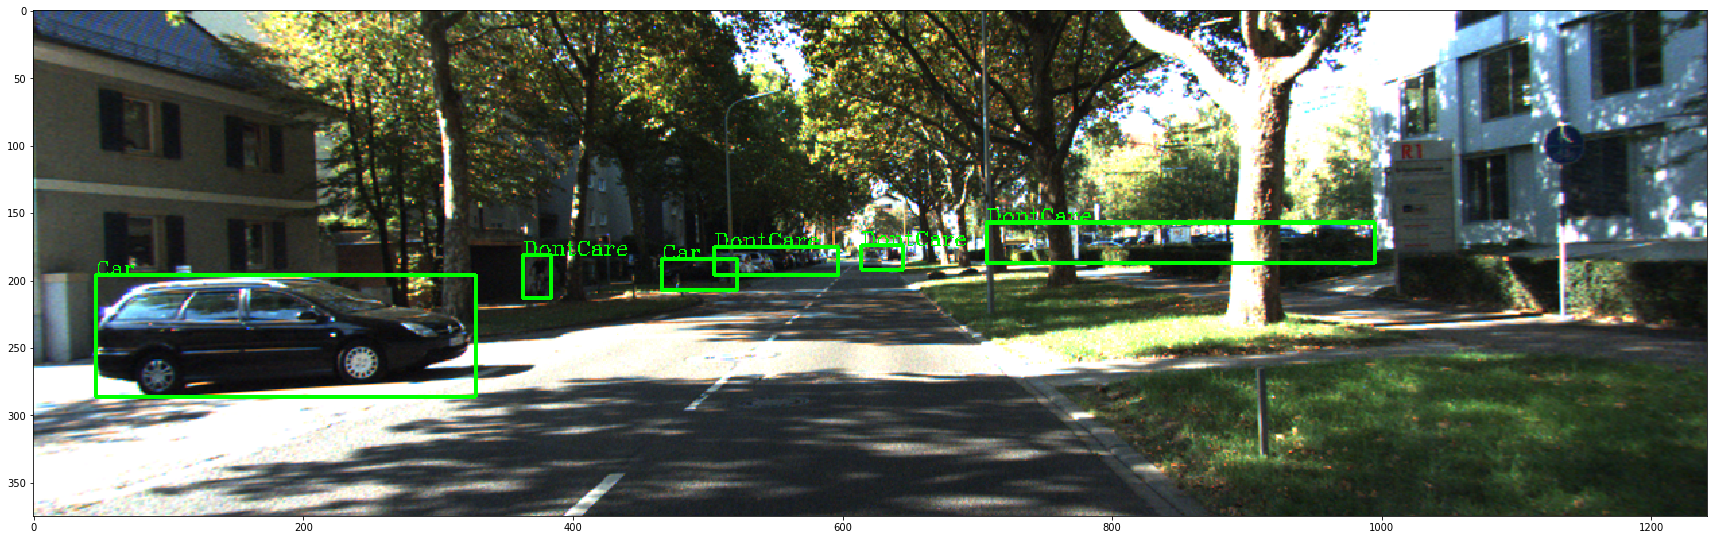

In [142]:
index = 34
plot_bbox_2d(index)

In [32]:
def draw_lidar(lidar, is_grid=False, is_axis = False, is_top_region=True, fig=None):
    pxs=lidar[:,0]
    pys=lidar[:,1]
    pzs=lidar[:,2]
    prs=lidar[:,3]
    
    if fig is None: fig = mlab.figure(figure=None, bgcolor=(0,0,0), fgcolor=None, engine=None, size=(1000, 500))
   
    mlab.points3d(
        pxs, pys, pzs, prs,
        mode='point',  # 'point'  'sphere'
        colormap='gnuplot',  #'bone',  #'spectral',  #'copper',
        scale_factor=1,
        figure=fig)
   
    #draw grid
    if is_grid:
        mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2,figure=fig)

        for y in np.arange(-50,50,1):
            x1,y1,z1 = -50, y, 0
            x2,y2,z2 =  50, y, 0
            mlab.plot3d([x1, x2], [y1, y2], [z1,z2], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)

        for x in np.arange(-50,50,1):
            x1,y1,z1 = x,-50, 0
            x2,y2,z2 = x, 50, 0
            mlab.plot3d([x1, x2], [y1, y2], [z1,z2], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)

    #draw axis
    if is_axis:
        mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2,figure=fig)

        axes=np.array([
            [2.,0.,0.,0.],
            [0.,2.,0.,0.],
            [0.,0.,2.,0.],
        ],dtype=np.float64)
        fov=np.array([  ##<todo> : now is 45 deg. use actual setting later ...
            [20., 20., 0.,0.],
            [20.,-20., 0.,0.],
        ],dtype=np.float64)

        mlab.plot3d([0, axes[0,0]], [0, axes[0,1]], [0, axes[0,2]], color=(1,0,0), tube_radius=None, figure=fig)
        mlab.plot3d([0, axes[1,0]], [0, axes[1,1]], [0, axes[1,2]], color=(0,1,0), tube_radius=None, figure=fig)
        mlab.plot3d([0, axes[2,0]], [0, axes[2,1]], [0, axes[2,2]], color=(0,0,1), tube_radius=None, figure=fig)
        mlab.plot3d([0, fov[0,0]], [0, fov[0,1]], [0, fov[0,2]], color=(1,1,1), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([0, fov[1,0]], [0, fov[1,1]], [0, fov[1,2]], color=(1,1,1), tube_radius=None, line_width=1, figure=fig)

    #draw top_image feature area
    
    if is_top_region:
        x1 = cfg.xrange[0]
        x2 = cfg.xrange[1]
        y1 = cfg.yrange[0]
        y2 = cfg.yrange[1]
        
        mlab.plot3d([x1, x1], [y1, y2], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([x2, x2], [y1, y2], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([x1, x2], [y1, y1], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)
        mlab.plot3d([x1, x2], [y2, y2], [0,0], color=(0.5,0.5,0.5), tube_radius=None, line_width=1, figure=fig)

    mlab.orientation_axes()
    mlab.view(azimuth=180,elevation=None,distance=50,focalpoint=[ 12.0909996 , -1.04700089, -2.03249991])#2.0909996 , -1.04700089, -2.03249991
    #out_path ="imgs/lidar.jpg"
    #mlab.close()
    return fig


In [143]:
def plot_bbox3d(lidars,bbox3d, cal_Tr, fig, color_setting='uniform', line_width=2):
    
    for b in bbox3d:
        if b[0] not in classes:
            continue
        if color_setting== 'uniform':
            color = (1,0,1)
        else:
            color = colors[classes.index(b[0])]
        b = list(map(lambda x:eval(x),b[1:]))
        b = box3d_cam_to_velo(b,cal_Tr)
        #print(b)
        for k in range(0,4):
            i,j=k,(k+1)%4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
            i,j=k+4,(k+3)%4 + 4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
            i,j=k,k+4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
    mlab.view(azimuth=180,elevation=None,distance=50,focalpoint=[ 12.0909996 , -1.04700089, -2.03249991])#2.0909996 , -1.04700089, -2.03249991
    out_path ="imgs/lidar.jpg"
    mlab.savefig(out_path)
    mlab.close()

In [144]:
#visualization of 3d-bbox

file_name = "%06d"%(index)
lidar_path = os.path.join(parent_pth,'training', "velodyne",file_name+'.bin')
image_path = os.path.join(parent_pth,'training', "image_2",file_name+'.png')
calib_path = os.path.join(parent_pth,'training', "calib",file_name+'.txt')
label_path = os.path.join(parent_pth,'training', "label_2",file_name+'.txt')
lidars = read_velodyne_points(lidar_path)
lidars,indices = prepare_velodyne_points(lidars,range_x =range_x,range_y=range_y,range_z = range_z)
cal_dict = read_cal(cal_path)
fig = draw_lidar(lidars, is_grid=False, is_axis = False,is_top_region=False, fig=None)
_, bbox3d = read_label_for_vis(label_path)
#print(bbox3d)
plot_bbox3d(lidars,bbox3d,cal_dict['Tr_velo_to_cam'],fig,color_setting='distinguished')

In [147]:
%%html
<img src="imgs/lidar.jpg" width="100%">
bboxes 3d in lidar pt cloud

[[48.500587    9.949506   -0.18103892]
 [50.020485    9.967126   -0.18103892]
 [50.061058    6.4673615  -0.18103892]
 [48.54116     6.449741   -0.18103892]]
[[15.259874    6.0230827  -0.35795167]
 [13.550216    5.988885   -0.35795167]
 [13.460222   10.487985   -0.35795167]
 [15.16988    10.522182   -0.35795167]]


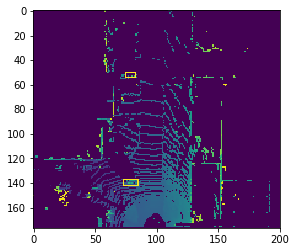

In [185]:
def scale_to_255(a, min, max, dtype=np.uint8):
    return (((a - min) / float(max - min)) * 255).astype(dtype)

def point_cloud_2_birdseye(points,
                           res=0.4,
                           side_range=range_y,  
                           fwd_range =range_x, 
                           height_range=range_z, 
                           ):
  
    # EXTRACT THE POINTS FOR EACH AXIS
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]

    f_filt = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt = np.logical_and((y_points > side_range[0]), (y_points < side_range[1]))
    filter = np.logical_and(f_filt, s_filt)
    indices = np.argwhere(filter).flatten()
    # KEEPERS
    x_points = x_points[indices]
    y_points = y_points[indices]
    z_points = z_points[indices]

    s0 = np.ones([len(y_points),])*np.abs(side_range[0]-0)
    f0 = np.ones([len(x_points),])*np.abs(fwd_range[1]-fwd_range[0])
    x_img = ((-side_range[0]-y_points)/res).astype(np.int32) 
    y_img = ((fwd_range[1]-fwd_range[0]-x_points)/res).astype(np.int32) 
    
    
    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a=z_points,
                           a_min=height_range[0],
                           a_max=height_range[1])

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    pixel_values = scale_to_255(pixel_values,
                                min=height_range[0],
                                max=height_range[1])

    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = 1 + int((side_range[1] - side_range[0]) / res)
    y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    im[y_img, x_img] = pixel_values
    return im

def bbox3d_2_birdeye(points,
                     mode = "largest_area",
                     res=0.4,
                     fwd_range =range_x, # back-most to forward-most
                     side_range=range_y,  # left-most to right-most
                     height_range=range_z):  # bottom-most to upper-most
    
    z_points = points[:, 2]
    if mode != "largest_area":
        keep_index = np.array(z_points.argsort()[-4:][::-1])
        points = points[keep_index,:]
        print(points)
        
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]
    f_filt = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt = np.logical_and((y_points > side_range[0]), (y_points < side_range[1]))
    filter = np.logical_and(f_filt, s_filt)
    indices = np.argwhere(filter).flatten()
    x_points = x_points[indices]
    y_points = y_points[indices]
    z_points = z_points[indices]

    x_img = ((-side_range[0]-y_points)/res).astype(np.int32) 
    y_img = ((fwd_range[1]-fwd_range[0]-x_points)/res).astype(np.int32) 

    x_min = min(x_img)
    x_max = max(x_img)
    y_min = min(y_img)
    y_max = max(y_img)
    return x_min,y_min,x_max,y_max

file_name = "%06d"%(index)
lidar_path = os.path.join(parent_pth,'training', "velodyne",file_name+'.bin')
image_path = os.path.join(parent_pth,'training', "image_2",file_name+'.png')
calib_path = os.path.join(parent_pth,'training', "calib",file_name+'.txt')
label_path = os.path.join(parent_pth,'training', "label_2",file_name+'.txt')

cal_dict = read_cal(cal_path)
lidars = read_velodyne_points(lidar_path)
lidars,indices = prepare_velodyne_points(lidars,range_x =range_x,range_y=range_y,range_z = range_z)
_, bbox3d = read_label_for_vis(label_path)

img = point_cloud_2_birdseye(lidars)

for b in bbox3d:
    if b[0] not in classes:
        continue
    b = list(map(lambda x:eval(x),b[1:]))
    b = box3d_cam_to_velo(b,cal_dict['Tr_velo_to_cam'])
    bbox_bev = bbox3d_2_birdeye(b,mode ="top")
    cv2.rectangle(img,(bbox_bev[0], bbox_bev[1]), (bbox_bev[2], bbox_bev[3]), (255,255,0),1)    

plt.imshow(img)
plt.show()

In [95]:
  
def test():
    lidar_path = os.path.join('./data/training', "crop/")
    image_path = os.path.join('./data/training', "image_2/")
    calib_path = os.path.join('./data/training', "calib/")
    label_path = os.path.join('./data/training', "label_2/")

    file=[i.strip().split('/')[-1][:-4] for i in sorted(os.listdir(label_path))]

    i=2600

    lidar_file = lidar_path + '/' + file[i] + '.bin'
    calib_file = calib_path + '/' + file[i] + '.txt'
    label_file = label_path + '/' + file[i] + '.txt'
    image_file = image_path + '/' + file[i] + '.png'

    image = cv2.imread(image_file)
    print("Processing: ", lidar_file)
    lidar = np.fromfile(lidar_file, dtype=np.float32)
    lidar = lidar.reshape((-1, 4))

    calib = load_kitti_calib(calib_file)
    gt_box3d = load_kitti_label(label_file, calib['Tr_velo2cam'])

    # augmentation
    lidar, gt_box3d = aug_data(lidar, gt_box3d)

    # filtering
    lidar, gt_box3d = get_filtered_lidar(lidar, gt_box3d)

    # view in point cloud
    # fig = draw_lidar(lidar, is_grid=False, is_top_region=True)
    # draw_gt_boxes3d(gt_boxes3d=gt_box3d, fig=fig)
    # mlab.show()

    # view in image
    # gt_3dTo2D = project_velo2rgb(gt_box3d, calib)
    # img_with_box = draw_rgb_projections(image,gt_3dTo2D, color=(0,0,255),thickness=1)
    # plt.imshow(img_with_box[:,:,[2,1,0]])
    # plt.show()

    # view in bird-eye view

    #top_new, density_image=lidar_to_bev(lidar)
    # gt_box3d_top = corner_to_standup_box2d_batch(gt_box3d)
    # density_with_box = draw_rects(density_image,gt_box3d_top)
    #density_with_box = draw_polygons(density_image,gt_box3d[:,:4,:2])
    #plt.imshow(density_with_box,cmap='gray')
    #plt.show()